# Постановка задачи

Допустим, некоторой компании необходимо разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы её сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах.

Получается, такой компании нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.


# Детекция лица на изображении и поиск ключевых точек с помощью dlib

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from PIL import Image
import numpy as np
import dlib
from skimage import io
from skimage import transform as transformation
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "deeplake<4"

In [ ]:
!pip install azure

In [ ]:
import deeplake
ds = deeplake.load('hub://activeloop/lfw')

In [ ]:
# Создаем папку для сохранения изображения
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Извлечение одного изображения из датасета
image_index = 0  # индекс изображения
image_data = ds['images'][image_index].numpy()  # преобразуем изображение в тип numpy

# Преобразуем numpy array в изображение PIL
image = Image.fromarray((image_data).astype(np.uint8))

# Сохраняем изображение
output_path = os.path.join(output_folder, f"lfw_image_{image_index}.jpg")
image.save(output_path)

print(f"Изображение сохранено по пути: {output_path}")

In [ ]:
image_path = output_path

Будем детектировать все лица на изображении, но работать будем только с одним лицом с этого изображения и находить для этого лица ключевые точки.

In [ ]:
image = io.imread(image_path)
detector = dlib.get_frontal_face_detector()
face_rects = list(detector(image, 1))
face_rect = face_rects[0]

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(image)
# Здесь мы добавим прямоугольник на изображение
rect = patches.Rectangle(
    (face_rect.left(), face_rect.top()),  # верхний левый угол
    face_rect.width(),                   # ширина
    face_rect.height(),                  # высота
    linewidth=2,                         # толщина линии
    edgecolor='red',                     # цвет линии
    facecolor='none'                     # без заливки
)
ax.add_patch(rect)

plt.axis("off")
plt.show()

In [ ]:
template_path = '/content/drive/MyDrive/Datasets Deep Learning/face_template.npy'
face_template = np.load(template_path)

In [ ]:
dlib_predictor_path = '/content/drive/MyDrive/Datasets Deep Learning/shape_predictor_68_face_landmarks.dat'

In [ ]:
predictor = dlib.shape_predictor(dlib_predictor_path)
points = predictor(image, face_rect)
landmarks = np.array(list(map(lambda p: [p.x, p.y], points.parts())))

In [ ]:
x = np.array(list(map(lambda p: p.x, points.parts())))
y = np.array(list(map(lambda p: p.y, points.parts())))

Всего предиктор предсказал 68 ключевых точек лица, но мы ограничимся тремя точками, так как этого достаточно для задачи выравнивания. Это внутренние точки глаз и точка на нижней губе.

In [ ]:
inner_eyes_and_bottom_lip = [39, 42, 57]

In [ ]:
current_landmarks = landmarks[inner_eyes_and_bottom_lip]

In [ ]:
current_landmarks

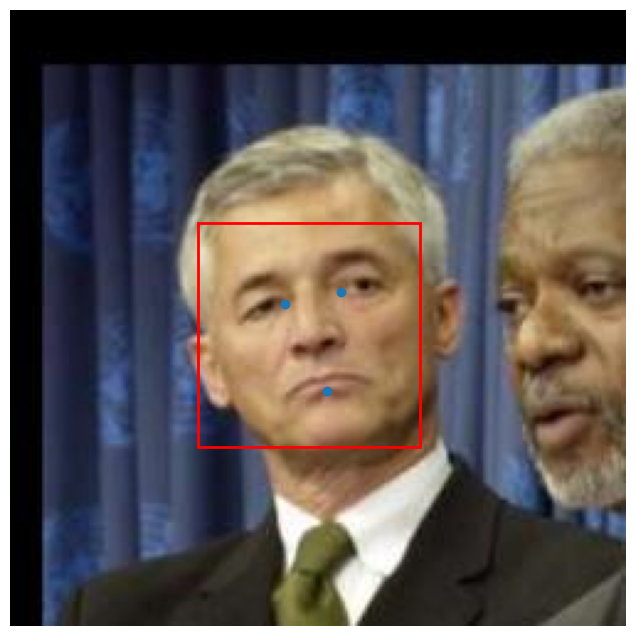

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(current_landmarks[:, 0], current_landmarks[:, 1])
ax.imshow(image)
# Здесь мы добавим прямоугольник на изображение
rect = patches.Rectangle(
    (face_rect.left(), face_rect.top()),  # верхний левый угол
    face_rect.width(),                   # ширина
    face_rect.height(),                  # высота
    linewidth=2,                         # толщина линии
    edgecolor='red',                     # цвет линии
    facecolor='none'                     # без заливки
)
ax.add_patch(rect)

plt.axis("off")
plt.show()

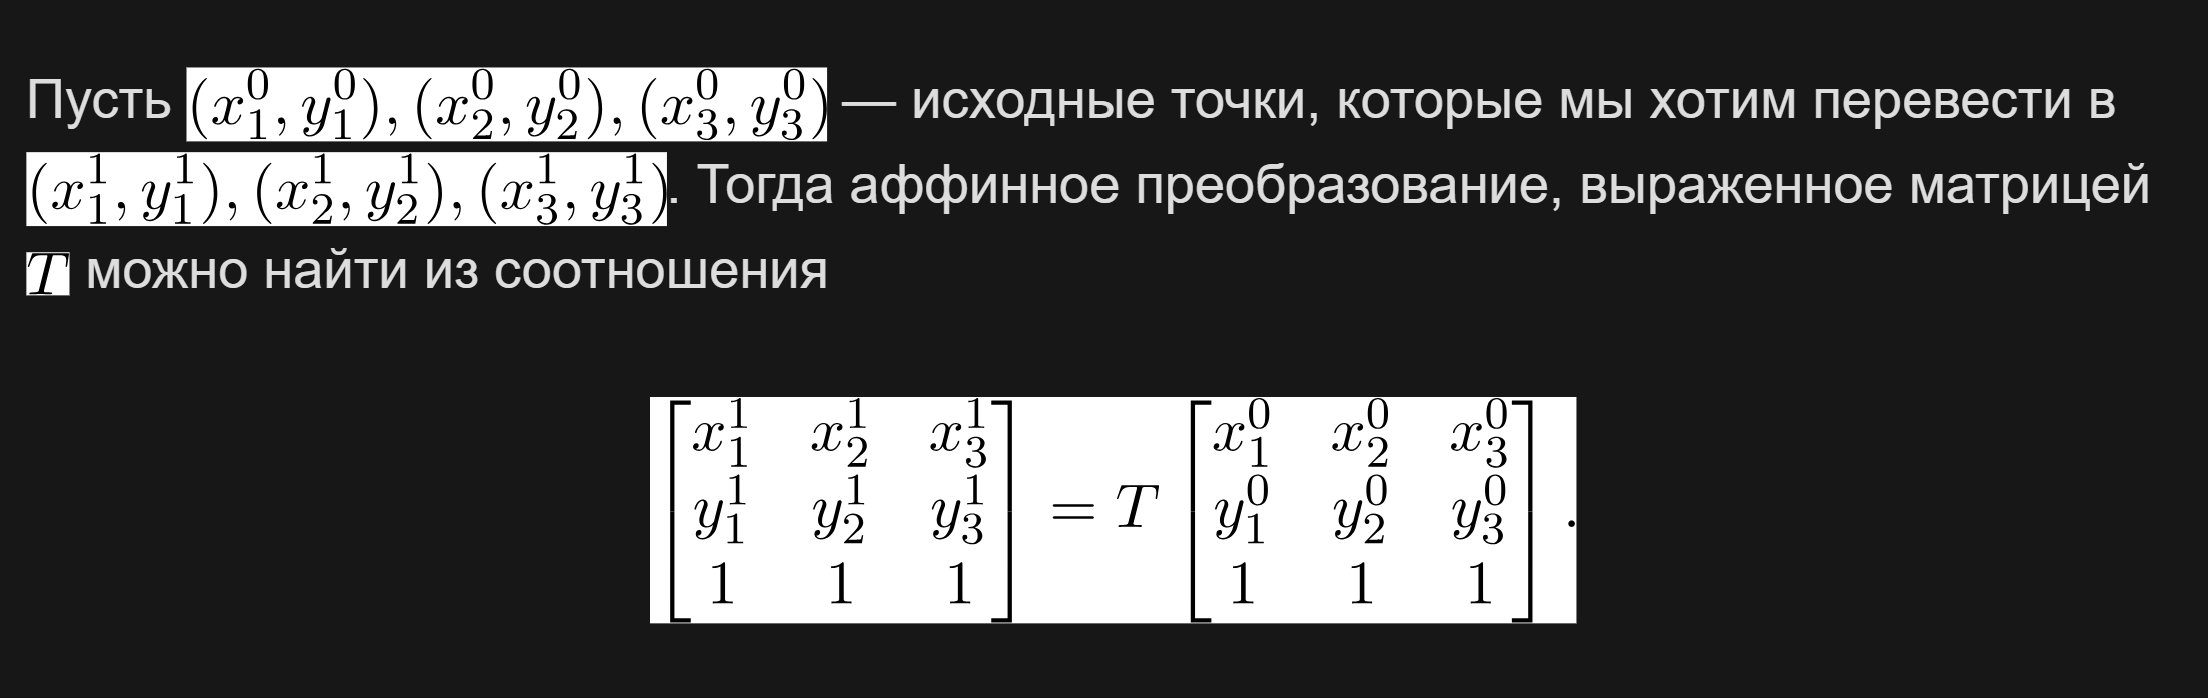

In [ ]:
proper_landmarks = 224 * face_template[inner_eyes_and_bottom_lip]
A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
T = np.linalg.solve(A, B).T

In [ ]:
wrapped = transformation.warp(
    image,
    transformation.AffineTransform(T).inverse,
    output_shape=(224, 224),
    order=3,
    mode='constant',
    cval=0,
    clip=True,
    preserve_range=True
)

wrapped /= 255.0

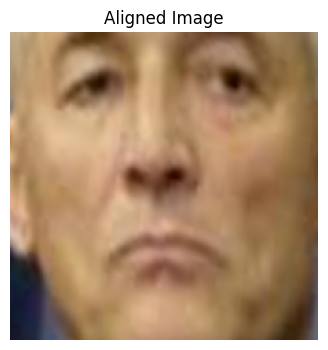

In [ ]:
plt.figure(figsize = (4, 4))
plt.imshow(wrapped)
plt.axis('off')
plt.title("Aligned Image")
plt.show()

# Создание датасета для задачи поиска ключевых точек на основе датасета LFW

 Создадим датасет, который в дальнейшем будем использовать для обучения модели поиска ключевых точек. В нём каждому изображения лица будут соответствовать координаты трёх ключевых точек лица: две координаты глаз, а также координата нижней губы. Для создания такого датасета я использую датасет LFW. Применяя библиотеку dlib, мы будем детектировать лица из датасета LFW и отмечать на них ключевые точки, тем самым сформируем необходимый нам датасет. Далее напишем архитектуру свёрточной нейросети и попробуем обучить её на данном датасете.

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(dlib_predictor_path)

In [ ]:
output_folder = '/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/images'

In [ ]:
os.makedirs('/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/images', exist_ok = True)

In [ ]:
data = {"image_name": []}
for i in range(3):  # Для 3 ключевых точек
    data[f"part_{i}_x"] = []
    data[f"part_{i}_y"] = []

In [ ]:
for idx, image in enumerate(ds['images']):
  image_data = image.numpy()
  image = image_data.astype(np.uint8)
  image_name = f"lfw_image_{idx}.jpg"
  output_path = os.path.join(output_folder, image_name)

  # детектируем лицо на изображении
  face_rects = list(detector(image, 1))
  if len(face_rects) == 0:
      print(f"Лицо не найдено на изображении {idx}")
      continue

  face_rect = face_rects[0]

  # находим ключевые точки лица
  points = predictor(image, face_rect)
  landmarks = np.array(list(map(lambda p: [p.x, p.y], points.parts())))
  current_landmarks = landmarks[inner_eyes_and_bottom_lip]

  # сохраняем в качестве итогового изображения только лицо (то есть то, что внутри прямоугольника)
  x1, y1, x2, y2 = face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()
  # проверка, что координаты находятся в пределах изображения
  x1 = max(0, x1)
  y1 = max(0, y1)
  x2 = min(image.shape[1], x2)
  y2 = min(image.shape[0], y2)

  # выразаем область лица
  face_image = image[y1:y2, x1:x2]
  if face_image.size == 0:
    print(f"Ошибка: пустое изображение для {idx}")
    continue

  # сохраняем обрезанное изображение в новую папку
  io.imsave(output_path, face_image)
  data["image_name"].append(image_name)

  for i, (x, y) in enumerate(current_landmarks):
    data[f"part_{i}_x"].append(x - x1)
    data[f"part_{i}_y"].append(y - y1)

df = pd.DataFrame(data)

Датасет находится в виде .csv файла с аннотациями, которые выглядят как:

```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x
0805personali01.jpg,27,83,27,98,84,134
1084239450_e76e00b7e7.jpg,70,236,71,257,128,312
```



In [ ]:
df.to_csv('/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/annotations.csv', index = False) # формируем csv файл с аннотациями

In [ ]:
df.dtypes

Функция вывода изображения и его ключевых точек и пример работы этой функции

In [8]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

Распакуем архив с нашим датасетом

In [ ]:
!unzip -uq "/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset.zip" -d "/content/drive/MyDrive/Datasets Deep Learning"

Создадим дата фрейм с названиями изображений и ключевыми точками для удобства работы

In [24]:
landmarks_frame = pd.read_csv('/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/annotations.csv')

In [ ]:

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

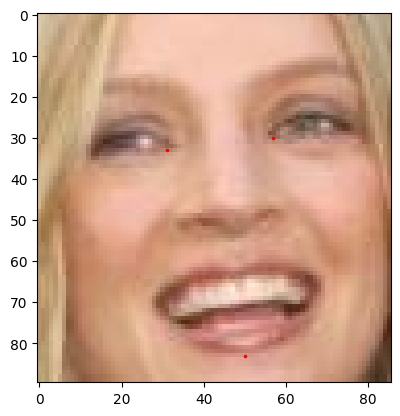

In [ ]:
plt.figure()
show_landmarks(io.imread(os.path.join('/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/images', img_name)),
               landmarks)
plt.show()

# Кастомные Dataset, DataLoader и Transforms

*Кастомный класс*

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
!unzip -uq "/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset.zip" -d "/content/drive/MyDrive/Datasets Deep Learning"

0 (90, 89, 3) (3, 2)


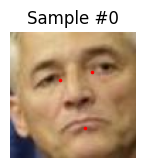

1 (107, 108, 3) (3, 2)


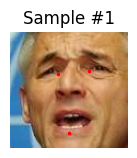

2 (90, 89, 3) (3, 2)


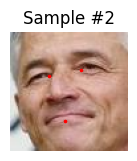

3 (90, 89, 3) (3, 2)


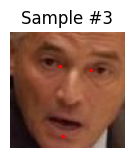

In [9]:
face_dataset = FaceLandmarksDataset(csv_file='/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/annotations.csv',
                                    root_dir='/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/images')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

*Классы трансформаций*

In [10]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transformation.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

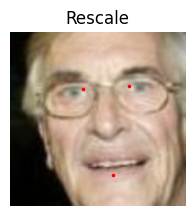

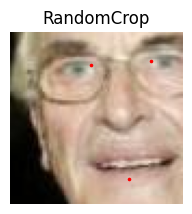

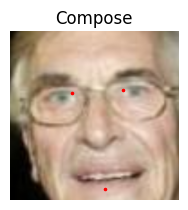

In [16]:
scale = Rescale(256)
crop = RandomCrop(80)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[64]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.axis('off')
    show_landmarks(**transformed_sample)

plt.show()

In [17]:
transformed_dataset = FaceLandmarksDataset(csv_file='/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/annotations.csv',
                                           root_dir='/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/images',
                                           transform=transforms.Compose([
                                               Rescale((224, 224)),
                                               ToTensor()]))

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([3, 2])
1 torch.Size([3, 224, 224]) torch.Size([3, 2])
2 torch.Size([3, 224, 224]) torch.Size([3, 2])
3 torch.Size([3, 224, 224]) torch.Size([3, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 2])


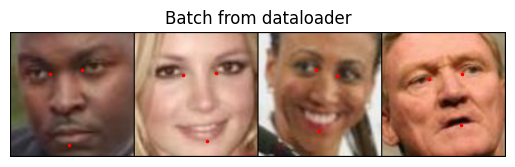

In [19]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

*Создадим тренировочный, валидационный и тестовый датасеты*

In [20]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [25]:
train_indices, test_indices = train_test_split(range(len(landmarks_frame)), test_size=0.2, random_state=42, shuffle = True)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42, shuffle = True)

train_dataset = Subset(transformed_dataset, train_indices)
val_dataset = Subset(transformed_dataset, val_indices)
test_dataset = Subset(transformed_dataset, test_indices)

In [26]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

In [27]:
print(f'Размер train: {train_size}, размер val: {val_size}, размер test: {test_size}')

Размер train: 7905, размер val: 2635, размер test: 2636


*Создадим тренировочный, валидационный и тестовый DataLoader'ы*

In [28]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# Модель поиска ключевых точек, функции обучения и тестирования

In [29]:
from tqdm import tqdm
import time

In [30]:
class KeypointModel(nn.Module):
    def __init__(self):
        super(KeypointModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 6)  # число нейронов на выходе = 6: соответствует количеству координат ключевых точек (x1, y1, x2, y2, x3, y3)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [31]:
class EarlyStopping:
  def __init__(self, mode = 'min', patience = 10, threshold = 0.0001, threshold_mode = 'rel'):
    '''
    Параметры:
        mode (str): режим изменения отслеживаемого параметра, 'min' или 'max'
        patience (int): количество эпох, по истечении которого срабатывает критерий останова
        threshold (float): порог изменения отслеживаемого параметра
        threshold_mode (str): режим сравнения (абсолютное или относительное изменение)
    '''
    # проверка, что переданные параметры имеют правильные значения
    if mode not in ['min', 'max']:
      raise ValueError(f'Параметр mode может принимать только значения max и min')
    if threshold_mode not in ('rel', 'abs'):
      raise ValueError(f'Параметр threshold_made может принимать только значения abs и rel')
    if not isinstance(patience, int):
      raise TypeError(f'Параметр patience может принимать только целые значения')
    if not isinstance(threshold, float):
      raise TypeError(f'Параметр threshold должен быть float и < 1.0')
    if threshold >= 1.0:
      raise ValueError(f'Параметр threshold должен быть < 1.0')

    self.mode = mode
    self.patience = patience
    self.threshold = threshold
    self.threshold_mode = threshold_mode
    self.count = 0
    self.best = None

  def __call__(self, tracking_parameter):
    '''
    Параметры:
        tracking_parameter: значение функции потерь или значение метрики

    '''
    current = float(tracking_parameter)
    # если лучшее значение отслеживаемого параметра не задано, то задаём его
    if self.best is None:
      self.best = current
      return False

    # проверяем улучшила ли модель значение отслеживаемого параметра
    if self.changed_better(current, self.best): # если да, то обнуляем значения счётчика
      self.best = current
      self.count = 0
    else:
      self.count += 1 # если значение отслеживаемого параметра не улучшилось, увеличиваем счётчик на 1

    if self.count >= self.patience: # если превышается значение "терпения", то обучение останавливается
      self.count = 0
      return True
    return False

  def changed_better(self, current, best):
    '''
    Проверяет, улучшила ли модель свои показатели

    Параметры:
        current (float): текущее значение отслеживаемого параметра
        best (float): лучшее значение отслеживаемого параметра
    '''
    if self.mode == 'min' and self.threshold_mode == 'rel':
      return current < best - best * self.threshold

    elif self.mode == 'min' and self.threshold_mode == 'abs':
      return current < best - self.threshold

    elif self.mode == 'max' and self.threshold_mode == 'rel':
      return current > best + best * self.threshold

    else:
      return current > best + self.threshold


In [32]:
def train_model(model, train_loader, val_loader, criterion, optimizer, earlystopping, lr_scheduler, start_epoch, num_epochs):
  total_time = 0
  train_loss = []
  val_loss = []
  lr_list = []
  best_loss = None
  count = 0 # отсчёт эпох, в которых нет улучшения лосса
  for epoch in range(start_epoch, start_epoch + num_epochs):
    # тренировка модели
    start_time = time.time()
    model.train()
    running_train_loss = []
    running_val_loss = []
    train_loop = tqdm(train_loader, leave = False)
    for sample in train_loop:
        x, targets = sample['image'], sample['landmarks']
        x, targets = x.float(), targets.float()  # приводим к типу float 32
        targets = targets.view(targets.size(0), -1)
        x, targets = x.to(device), targets.to(device)

        # прямой проход + подсчёт ошибки модели
        preds = model(x)
        loss = criterion(preds, targets)

        # обратный проход
        optimizer.zero_grad()
        loss.backward()
        # шаг оптимизации
        optimizer.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        train_loop.set_description(f'Epoch [{epoch}/{start_epoch + num_epochs - 1}], train_loss={mean_train_loss:.4f}')

    # Сохранение значения функции потерь
    train_loss.append(mean_train_loss)

    # Валидация модели
    model.eval()
    with torch.no_grad():
        for sample in val_loader:
            x, targets = sample['image'], sample['landmarks']
            x, targets = x.float(), targets.float()  # приводим к типу float 32
            targets = targets.view(targets.size(0), -1)
            x, targets = x.to(device), targets.to(device)

            # прямой проход и расчет ошибки модели
            preds = model(x)
            loss = criterion(preds, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

        # Сохранение значения функции потерь
        val_loss.append(mean_val_loss)

    lr_scheduler.step()
    last_lr = lr_scheduler._last_lr[0]
    lr_list.append(last_lr)

    total_time += time.time() - start_time
    print(f'Epoch [{epoch}/{start_epoch + num_epochs - 1}], train_loss: {mean_train_loss:.5f}, val Loss: {mean_val_loss:.5f}, time taken: {time.time() - start_time:.2f} seconds')

    if best_loss is None:
        best_loss = mean_val_loss

    if mean_val_loss < best_loss: # если модель улучшила лосс, отсчёт эпох идёт заново
        best_loss = mean_val_loss
        count = 0

        checkpoint = {
            'state_model': model.state_dict(),
            'state_opt': optimizer.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss': {'train_loss': train_loss,
                     'val_loss': val_loss,
                     'best_loss': best_loss
            },
            'lr': lr_list,
            'epoch': {
                'EPOCHS': num_epochs,
                'save_epoch': epoch
            },
            'total_time': total_time
        }
        torch.save(checkpoint, f'model_state_dict_epoch_{epoch}.pt')
        print(f"Сохранена модель со значением val loss = {mean_val_loss:.4f} на эпохе {epoch}")

    if earlystopping(mean_val_loss):
      print(f"\033[31mОбучение остановлено на {epoch} эпохе.\033[0m")
      break
  return {
            'state_model': model.state_dict(),
            'state_opt': optimizer.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss': {'train_loss': train_loss,
                     'val_loss': val_loss,
                     'best_loss': best_loss
            },
            'lr': lr_list,
            'epoch': {
                'EPOCHS': num_epochs,
                'save_epoch': epoch
            },
            'train_val_time': total_time
        }

In [33]:
def test_model(model, test_loader, criterion):
  start_time = time.time()
  running_test_loss = []
  model.eval()
  with torch.no_grad():
    for sample in test_loader:
      x, targets = sample['image'], sample['landmarks']
      x, targets = x.float(), targets.float()  # приводим к типу float 32
      targets = targets.view(targets.size(0), -1)
      x, targets = x.to(device), targets.to(device)

      # прямой проход и расчет ошибки модели
      preds = model(x)
      loss = criterion(preds, targets)

      running_test_loss.append(loss.item())
      mean_test_loss = sum(running_test_loss)/len(running_test_loss)

      return {'test loss': mean_test_loss, 'test time': time.time() - start_time}

# Обучение модели поиска ключевых точек

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [35]:
model = KeypointModel().to(device)
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma = 0.95)
earlystopping = EarlyStopping(mode = 'min', patience = 5)

Проверка того, что модель выдаёт результат верной размерности

In [ ]:
input = torch.rand([1, 3, 224, 224], dtype = torch.float32).to(device)
output = model(input)
output.shape

torch.Size([1, 6])

Обучим модель 10 эпох

In [ ]:
start_epoch = 1
num_epochs = 10

In [ ]:
first_pt_results = train_model(model, train_loader, val_loader, loss_model, opt, earlystopping, lr_scheduler, start_epoch, num_epochs)

Epoch [1/10], train_loss: 1129.75861, val Loss: 152.34448, time taken: 200.10 seconds


Epoch [2/10], train_loss: 122.92393, val Loss: 117.38004, time taken: 183.51 seconds
Сохранена модель со значением val loss = 117.3800 на эпохе 2


Epoch [3/10], train_loss: 115.89764, val Loss: 106.90674, time taken: 179.55 seconds
Сохранена модель со значением val loss = 106.9067 на эпохе 3


Epoch [4/10], train_loss: 76.10031, val Loss: 46.20362, time taken: 181.76 seconds
Сохранена модель со значением val loss = 46.2036 на эпохе 4


Epoch [5/10], train_loss: 43.64316, val Loss: 40.70854, time taken: 183.46 seconds
Сохранена модель со значением val loss = 40.7085 на эпохе 5


Epoch [6/10], train_loss: 35.25601, val Loss: 35.72818, time taken: 180.85 seconds
Сохранена модель со значением val loss = 35.7282 на эпохе 6


Epoch [7/10], train_loss: 36.59830, val Loss: 34.25938, time taken: 185.99 seconds
Сохранена модель со значением val loss = 34.2594 на эпохе 7


Epoch [8/10], train_loss: 33.37999, val Loss: 32.95592, time taken: 183.58 seconds
Сохранена модель со значением val loss = 32.9559 на эпохе 8


Epoch [9/10], train_loss: 31.25916, val Loss: 33.72221, time taken: 186.20 seconds


Epoch [10/10], train_loss: 30.34989, val Loss: 31.49700, time taken: 192.51 seconds
Сохранена модель со значением val loss = 31.4970 на эпохе 10


In [122]:
load_model_state = torch.load('/content/drive/MyDrive/model_states/KeyPointModel/model_state_dict_epoch_10.pt')

In [123]:
model.load_state_dict(load_model_state['state_model'])
opt.load_state_dict(load_model_state['state_opt'])
lr_scheduler.load_state_dict(load_model_state['state_lr_scheduler'])

In [124]:
EPOCHS = load_model_state['epoch']['EPOCHS'] # сколько всего эпох обучаться модели
save_epoch = load_model_state['epoch']['save_epoch'] # эпоха, на которой модель сохранена (дообучать модель мы будем с save_epoch + 1 эпохи)

train_loss = load_model_state['loss']['train_loss']
val_loss = load_model_state['loss']['val_loss']
lr_list = load_model_state['lr']

best_loss = load_model_state['loss']['best_loss']
total_time = load_model_state['total_time']

In [125]:
train_loss_epochs_1_10 = train_loss.copy() # сохраняем значения функции потерь на эпохах с 1 по 10
val_loss_epochs_1_10 = val_loss.copy()

In [ ]:
total_time

1857.5098917484283

Выведем список learning rate'ов на всех эпохах и посмотрим последний learning rate: 0.000598

In [ ]:
lr_list

[0.00095,
 0.0009025,
 0.000857375,
 0.0008145062499999999,
 0.0007737809374999998,
 0.0007350918906249997,
 0.0006983372960937497,
 0.0006634204312890621,
 0.000630249409724609,
 0.0005987369392383785]

Изменим скорость обучения модели в 10 раз, сделав lr = 0.0001

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr = 0.0001)
start_epoch = 11
num_epochs = 10

In [ ]:
train_model(model, train_loader, val_loader, loss_model, opt, earlystopping, lr_scheduler, save_epoch + 1, num_epochs)

Epoch [11/20], train_loss: 31.54277, val Loss: 29.07395, time taken: 185.70 seconds


Epoch [12/20], train_loss: 26.14586, val Loss: 28.10384, time taken: 195.98 seconds
Сохранена модель со значением val loss = 28.1038 на эпохе 12


Epoch [13/20], train_loss: 25.83551, val Loss: 28.76511, time taken: 190.78 seconds


Epoch [14/20], train_loss: 25.85650, val Loss: 32.79400, time taken: 185.50 seconds


Epoch [15/20], train_loss: 25.32894, val Loss: 26.79928, time taken: 186.04 seconds
Сохранена модель со значением val loss = 26.7993 на эпохе 15


Epoch [16/20], train_loss: 24.74843, val Loss: 28.22216, time taken: 183.14 seconds


Epoch [17/20], train_loss: 24.95989, val Loss: 26.65523, time taken: 188.69 seconds
Сохранена модель со значением val loss = 26.6552 на эпохе 17


Epoch [18/20], train_loss: 24.40373, val Loss: 25.86336, time taken: 188.16 seconds
Сохранена модель со значением val loss = 25.8634 на эпохе 18


Epoch [19/20], train_loss: 23.78759, val Loss: 25.61565, time taken: 185.80 seconds
Сохранена модель со значением val loss = 25.6157 на эпохе 19


Epoch [20/20], train_loss: 23.90249, val Loss: 25.85060, time taken: 185.79 seconds


{'state_model': OrderedDict([('conv_layers.0.weight',
               tensor([[[[-1.7756e-01, -2.7603e-02,  1.8693e-01],
                         [ 1.5657e-01,  1.8839e-01, -3.4417e-02],
                         [ 1.9039e-01, -5.3718e-02,  2.8377e-02]],
               
                        [[ 5.9196e-03,  1.6474e-01, -1.5878e-01],
                         [ 1.9398e-02,  1.7485e-01, -2.3988e-02],
                         [-6.1423e-02, -3.2547e-02,  8.1793e-02]],
               
                        [[ 1.4089e-01,  6.9808e-02,  1.2561e-01],
                         [ 1.0342e-02,  7.8515e-02, -4.4185e-02],
                         [ 1.2814e-01,  1.6678e-01,  5.2257e-02]]],
               
               
                       [[[ 5.8874e-02,  4.6685e-02, -3.0373e-02],
                         [ 1.1239e-01,  1.7937e-01, -8.5773e-02],
                         [ 1.3797e-01, -1.6799e-01, -1.3225e-01]],
               
                        [[-1.7224e-01, -5.6025e-02,  5.8603e-02],
   

In [126]:
load_model_state = torch.load('/content/drive/MyDrive/model_states/KeyPointModel/model_state_dict_epoch_19.pt', map_location=device)

In [127]:
model.load_state_dict(load_model_state['state_model'])
opt.load_state_dict(load_model_state['state_opt'])
lr_scheduler.load_state_dict(load_model_state['state_lr_scheduler'])

In [128]:
EPOCHS = load_model_state['epoch']['EPOCHS'] # сколько всего эпох обучаться модели
save_epoch = load_model_state['epoch']['save_epoch'] # эпоха, на которой модель сохранена (дообучать модель мы будем с save_epoch + 1 эпохи)

train_loss = load_model_state['loss']['train_loss']
val_loss = load_model_state['loss']['val_loss']
lr_list = load_model_state['lr']

best_loss = load_model_state['loss']['best_loss']
total_time = load_model_state['total_time']

In [ ]:
lr_list

[0.0005688000922764595,
 0.0005403600876626365,
 0.0005133420832795047,
 0.00048767497911552944,
 0.00046329123015975297,
 0.0004401266686517653,
 0.00041812033521917703,
 0.00039721431845821814,
 0.0003773536025353072]

In [129]:
train_loss_epochs_11_19 = train_loss.copy() # сохраняем значения функции потерь на эпохах с 11 по 19
val_loss_epochs_11_19 = val_loss.copy()

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma = 0.95)
start_epoch = 20
num_epochs = 11

In [ ]:
third_pt_results = train_model(model, train_loader, val_loader, loss_model, opt, earlystopping, lr_scheduler, start_epoch, num_epochs)

Epoch [20/30], train_loss: 28.87526, val Loss: 25.46821, time taken: 1389.66 seconds


Epoch [21/30], train_loss: 22.99664, val Loss: 24.94976, time taken: 160.20 seconds
Сохранена модель со значением val loss = 24.9498 на эпохе 21


Epoch [22/30], train_loss: 22.79408, val Loss: 24.71389, time taken: 162.80 seconds
Сохранена модель со значением val loss = 24.7139 на эпохе 22


Epoch [23/30], train_loss: 22.63336, val Loss: 24.54447, time taken: 160.21 seconds
Сохранена модель со значением val loss = 24.5445 на эпохе 23


Epoch [24/30], train_loss: 22.27330, val Loss: 25.88954, time taken: 160.69 seconds


Epoch [25/30], train_loss: 22.24230, val Loss: 25.72524, time taken: 161.80 seconds


Epoch [26/30], train_loss: 22.29874, val Loss: 23.57848, time taken: 159.91 seconds
Сохранена модель со значением val loss = 23.5785 на эпохе 26


Epoch [27/30], train_loss: 21.47955, val Loss: 23.42980, time taken: 163.56 seconds
Сохранена модель со значением val loss = 23.4298 на эпохе 27


Epoch [28/30], train_loss: 21.56169, val Loss: 22.79416, time taken: 162.65 seconds
Сохранена модель со значением val loss = 22.7942 на эпохе 28


Epoch [29/30], train_loss: 21.16215, val Loss: 22.89205, time taken: 162.58 seconds


Epoch [30/30], train_loss: 20.38522, val Loss: 22.19116, time taken: 161.12 seconds
Сохранена модель со значением val loss = 22.1912 на эпохе 30


In [36]:
load_model_state = torch.load('/content/drive/MyDrive/model_states/KeyPointModel/model_state_dict_epoch_30.pt', map_location=device)

In [37]:
model.load_state_dict(load_model_state['state_model'])
opt.load_state_dict(load_model_state['state_opt'])
lr_scheduler.load_state_dict(load_model_state['state_lr_scheduler'])

In [38]:
EPOCHS = load_model_state['epoch']['EPOCHS'] # сколько всего эпох обучаться модели
save_epoch = load_model_state['epoch']['save_epoch'] # эпоха, на которой модель сохранена (дообучать модель мы будем с save_epoch + 1 эпохи)

train_loss = load_model_state['loss']['train_loss']
val_loss = load_model_state['loss']['val_loss']
lr_list = load_model_state['lr']

best_loss = load_model_state['loss']['best_loss']
total_time = load_model_state['total_time']

In [39]:
train_loss_epochs_20_30 = train_loss.copy() # сохраняем значения функции потерь на эпохах с 20 по 30
val_loss_epochs_20_30 = val_loss.copy()

In [41]:
total_time

3005.1867938041687

In [40]:
lr_list

[9.5e-05,
 9.025e-05,
 8.573749999999999e-05,
 8.145062499999998e-05,
 7.737809374999998e-05,
 7.350918906249998e-05,
 6.983372960937497e-05,
 6.634204312890622e-05,
 6.30249409724609e-05,
 5.987369392383786e-05,
 5.688000922764596e-05]

Обучим модель с новым, уменьшенным learning rate, на ещё 10 эпохах

In [42]:
opt = torch.optim.Adam(model.parameters(), lr = 0.00005)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma = 0.9)
start_epoch = 31
num_epochs = 10

In [43]:
fourth_part_results = train_model(model, train_loader, val_loader, loss_model, opt, earlystopping, lr_scheduler, start_epoch, num_epochs)

Epoch [31/40], train_loss: 22.32273, val Loss: 22.16441, time taken: 228.40 seconds


Epoch [32/40], train_loss: 19.59364, val Loss: 22.18967, time taken: 228.00 seconds


Epoch [33/40], train_loss: 19.53731, val Loss: 21.77906, time taken: 224.04 seconds
Сохранена модель со значением val loss = 21.7791 на эпохе 33


Epoch [34/40], train_loss: 19.38656, val Loss: 21.84772, time taken: 228.21 seconds


Epoch [35/40], train_loss: 19.25127, val Loss: 21.57915, time taken: 224.50 seconds
Сохранена модель со значением val loss = 21.5792 на эпохе 35


Epoch [36/40], train_loss: 19.23702, val Loss: 21.62829, time taken: 226.43 seconds


Epoch [37/40], train_loss: 19.09446, val Loss: 21.68283, time taken: 226.32 seconds


Epoch [38/40], train_loss: 19.08117, val Loss: 21.48480, time taken: 228.39 seconds
Сохранена модель со значением val loss = 21.4848 на эпохе 38


Epoch [39/40], train_loss: 18.99299, val Loss: 21.31335, time taken: 231.04 seconds
Сохранена модель со значением val loss = 21.3134 на эпохе 39


Epoch [40/40], train_loss: 18.80352, val Loss: 21.30049, time taken: 225.77 seconds
Сохранена модель со значением val loss = 21.3005 на эпохе 40


Сохраняем в отдельные переменные потери на train и val

In [55]:
train_loss_epochs_31_40 = fourth_part_results['loss']['train_loss']
val_loss_epochs_31_40 = fourth_part_results['loss']['val_loss']

# Проверка работы модели поиска ключевых точек на реальном изображении. Тестирование. Графики функции потерь

Посмотрим, как работает наша модель на произвольном изображении

In [44]:
landmarks_frame = pd.read_csv('/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/annotations.csv')

n = 10
img_name = landmarks_frame.iloc[n, 0]
true_landmarks = landmarks_frame.iloc[n, 1:]
true_landmarks = np.asarray(true_landmarks, dtype=float).reshape(-1, 2)

In [45]:
image = io.imread(os.path.join('/content/drive/MyDrive/Datasets Deep Learning/key_points_dataset/images', img_name))

In [46]:
image_pil = Image.fromarray(image)
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_tensor = transform(image_pil)
image_tensor = image_tensor.unsqueeze(0)
predicted_landmarks = model(image_tensor.to(device))
predicted_landmarks = predicted_landmarks.detach().cpu()
predicted_landmarks = predicted_landmarks.reshape(-1, 2).numpy()

In [47]:
true_landmarks = true_landmarks * [image_tensor.shape[2] / image.shape[0], image_tensor.shape[3] / image.shape[1]]

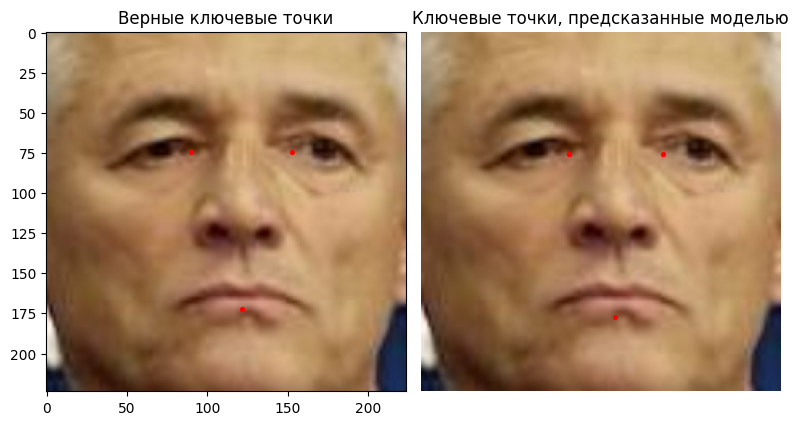

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (8, 16))
ax[0].imshow(image_tensor.squeeze(0).permute(1, 2, 0).numpy())
ax[0].scatter(true_landmarks[:, 0], true_landmarks[:, 1], s=30, marker='.', c='r')
ax[0].set_title('Верные ключевые точки')
ax[1].imshow(image_tensor.squeeze(0).permute(1, 2, 0).numpy())
ax[1].scatter(predicted_landmarks[:, 0], predicted_landmarks[:, 1], s=30, marker='.', c='r')
ax[1].set_title('Ключевые точки, предсказанные моделью')

plt.axis('off')
plt.tight_layout()
plt.show()

*Визуально видим, что модель достаточно неплохо справляется с поиском ключевых точек*

Так как текущие результаты устраивают, то далее модель дообучать не будем, протестируем модель на тестовой выборке и посмотрим на MSE Loss, а также построим графики функции потерь на тренировке и валидации.

In [50]:
test_results = test_model(model, test_loader, loss_model)

In [51]:
print(f'MSE Loss на тесте = {test_results["test loss"]:.4f}')

MSE Loss на тесте = 17.4484


In [52]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [130]:
losses_on_train = train_loss_epochs_1_10 + train_loss_epochs_11_19 + train_loss_epochs_20_30 + train_loss_epochs_31_40
losses_on_val = val_loss_epochs_1_10 + val_loss_epochs_11_19 + val_loss_epochs_20_30 + val_loss_epochs_31_40

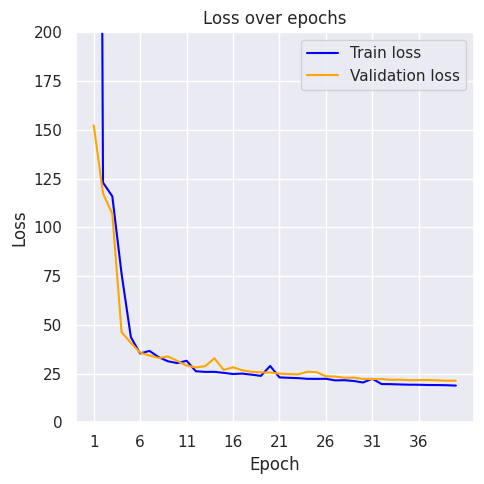

In [140]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

ax.plot(range(1, 41), losses_on_train, label = 'Train loss', color = 'blue')
ax.plot(range(1, 41), losses_on_val, label = 'Validation loss', color = 'orange')
ax.set_title('Loss over epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xticks(np.arange(1, 41, 5)) # установим только целые сеточные значения на оси х
ax.set_ylim(0, 200)
ax.legend()

plt.tight_layout()
plt.show()

# Детекция лиц + выравнивание

In [57]:
def align_face(image, current_landmarks, proper_landmarks):
  '''
  Performs affine transformations by aligning the face
    Args:
        image (numpy array): numpy array of image with shape (H, W, C)
        current_landmarks (numpy array): x and y coordinates of landmarks predicted by your model (3, 2)
        proper_landmarks (numpy array): x and y coordinates of true landmarks  (3, 2)
    Output:
        wrapped (numpy array): image after affine transformations
  '''
  # вычисляем аффинное преобразование
  A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
  B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
  T = np.linalg.solve(A, B).T
  # применяем аффинное преобразование к изображению
  wrapped = transformation.warp(
    image,
    transformation.AffineTransform(T).inverse,
    output_shape=(224, 224),
    order=3,
    mode='constant',
    cval=0,
    clip=True,
    preserve_range=True
  )

  wrapped /= 255.0

  return wrapped

In [58]:
def get_face_rects(image):
  '''
  Args:
      image (numpy array): numpy array of image with shape (H, W, C)
  Output:
      face_rects (list): list of face rects
  '''
  detector = dlib.get_frontal_face_detector()
  face_rects = list(detector(image, 1))
  return face_rects

In [59]:
def get_true_landmarks():
  '''
  Output:
      proper_landmarks (numpy array): array of true landmarks from dlib (3, 2)
  '''
  # находим правильные положения ключевых точек, которые заданы в dlib
  inner_eyes_and_bottom_lip = [39, 42, 57] # номера точек, соответствующих глазам и нижней губе
  template_path = '/content/drive/MyDrive/Datasets Deep Learning/face_template.npy'
  face_template = np.load(template_path)
  proper_landmarks = 224 * face_template[inner_eyes_and_bottom_lip] # находим искомые расположения ключевых точек
  return proper_landmarks

In [60]:
get_true_landmarks()

array([[ 81.48782815,  39.86009699],
       [138.647742  ,  38.70230014],
       [112.04568707, 168.1309021 ]])

In [61]:
def visualize_detection(image, face_rects):
  '''
  Visualizes detection rectangles in an image
    Args:
        image (numpy array): numpy array of image with shape (H, W, C)
        face_rects (list): list of face rects
  '''
  fig, ax = plt.subplots(figsize = (8, 8))
  ax.imshow(image)
  for face_rect in face_rects:
  # здесь мы добавим прямоугольник на изображение
    rect = patches.Rectangle(
      (face_rect.left(), face_rect.top()),  # верхний левый угол
      face_rect.width(),                   # ширина
      face_rect.height(),                  # высота
      linewidth=2,                         # толщина линии
      edgecolor='red',                     # цвет линии
      facecolor='none'                     # без заливки
    )
    ax.add_patch(rect)
    plt.title('Результат детекции лиц на изображении')
    plt.axis("off")
plt.show()

In [64]:
def face_alignment(image_folder, image_name, output_folder):
  '''
  Makes a folder with aligned images, visualises process of detection and alignment
  Args:
      image_folder (str): path to folder with image
      image_name (str): name of image
      output_folder (str): path to folder with aligned images
  Output:
      aligned_faces_paths (list): list of images paths

  '''
  image = io.imread(f'{image_folder}/{image_name}') # чтение изображения
  os.makedirs(output_folder, exist_ok = True) # создание папки для сохранения выровненных изображений
  aligned_faces_paths = []
  face_rects = get_face_rects(image) # находим прямоугольники, в которых находятся лица
  visualize_detection(image, face_rects) # визуализация выполненного детектирования
  for idx, face_rect in enumerate(face_rects):
    # находим ключевые координаты прямоугольника детекции
    x1, y1, x2, y2 = face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()
    # проверка, что координаты находятся в пределах изображения
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image.shape[1], x2)
    y2 = min(image.shape[0], y2)

    # вырезаем только область лица, соответствующего данному прямоугольнику
    face_image = image[y1:y2, x1:x2]

    image_pil = Image.fromarray(face_image) # приводим изображение лица к типу Image для дальнейшей трансформации изображения
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    image_tensor = transform(image_pil)
    image_tensor = image_tensor.unsqueeze(0) # добавляем размерность батча для подачи в модель
    predicted_landmarks = model(image_tensor.to(device)) # считаем выходы модели
    predicted_landmarks = predicted_landmarks.detach().cpu()
    predicted_landmarks_numpy = predicted_landmarks.reshape(-1, 2).numpy() # приводим ключевые точки к типу numpy array

    proper_landmarks = get_true_landmarks()

    # приводим image_tensor в тип, необходимый для подачи в функцию align_face
    image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image_numpy = (image_numpy * 255).astype('uint8') # изображение лица, готовое к подаче в функцию выравнивания

    wrapped_image = align_face(image_numpy, predicted_landmarks_numpy, proper_landmarks) #применяем функцию выравнивания лиц
    wrapped_image = (wrapped_image * 255).astype('uint8') # приводим wrapped_image к типу необходимому для сохранения

    # отображаем выровненные лица
    fig, ax = plt.subplots(1, 2, figsize = (8, 16))
    ax[0].scatter(predicted_landmarks_numpy[:, 0], predicted_landmarks_numpy[:, 1])
    ax[0].imshow(image_numpy)
    ax[0].set_title(f'Лицо {idx+1} + ключевые точки')
    ax[0].axis('off')

    ax[1].imshow(wrapped_image)
    ax[1].set_title(f'Выровненное лицо {idx+1}')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

    output_path = output_folder + f'/aligned_{image_name[:-4]}_{idx+1}.jpg'
    aligned_faces_paths.append(f'/aligned_{image_name[:-4]}_{idx+1}.jpg')
    io.imsave(output_path, wrapped_image)
  return aligned_faces_paths

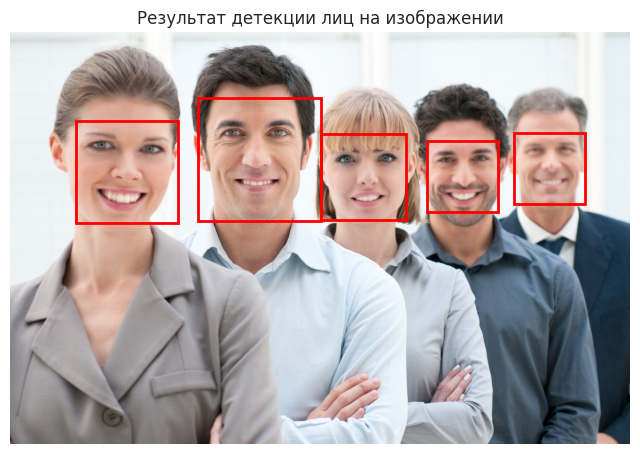

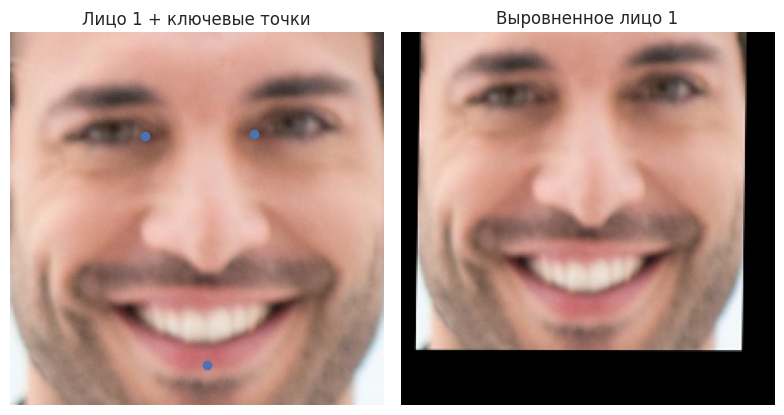

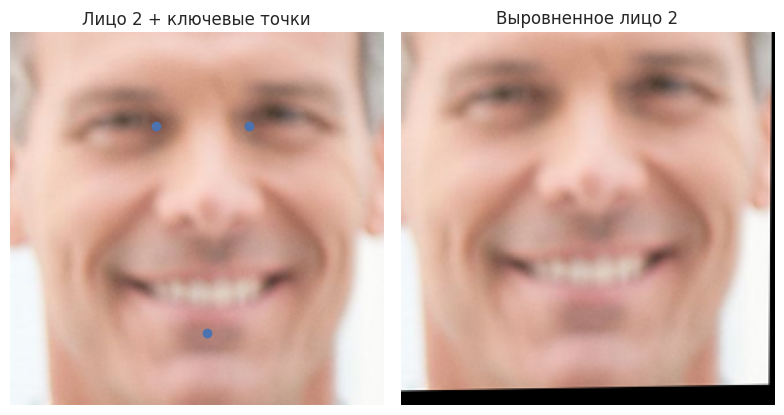

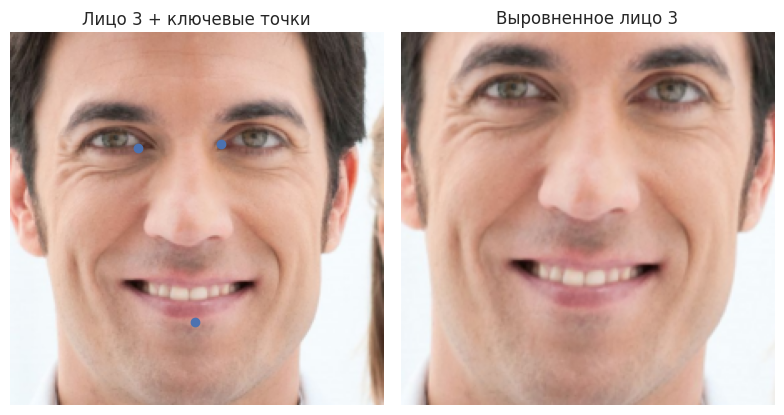

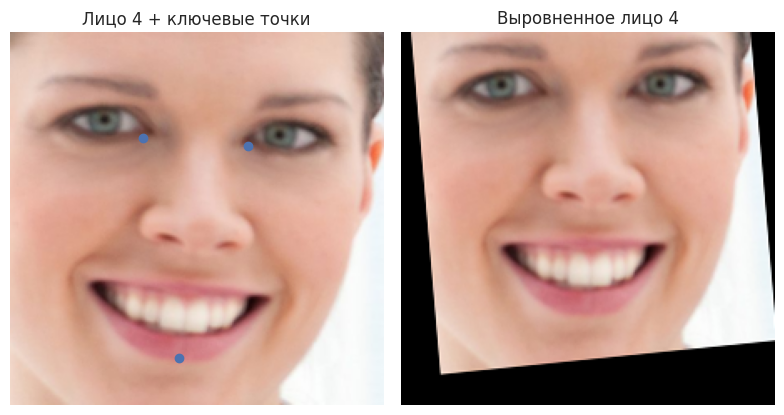

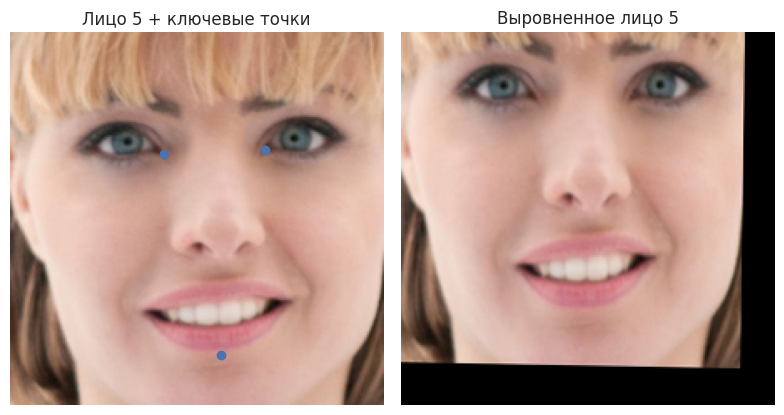

In [77]:
aligned_images_paths = face_alignment('/content/drive/MyDrive/Datasets Deep Learning/images for testing model/colleagues', 'colleagues.jpg', '/content/drive/MyDrive/Datasets Deep Learning/images for testing model/colleagues_aligned')

Видим, что выравнивание лиц происходит корректно. Минус в том, что появляются чёрные границы у изображений.

Думаю, этого можно было бы избежать, если бы удалось выбрать bounding box'ы покрупнее.

# Полный пайплайн распознавания лиц

В данном разделе мы соберём вместе реализованные ранее части пайплайна.

Этому пайплайну можно подать на вход картинку с лицами, и пайплайн вернёт эмбеддинги всех найденных лиц.

В завершение я продемонстрирую работу пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами

**Импорт обученной на ArcLoss модели resnet34**

In [69]:
import torch.nn.functional as F
import math
import torchvision.models as models
import torch.nn as nn

In [70]:
class ArcFace(nn.Module):
    """
    Имплементация ArcFace Loss (Additive Angular Margin Loss)

    Параметры:
        in_features (int): размерность входных эмбеддингов (512 в случае resnet34)
        out_features (int): количество классов
        s (float): scale коэффициент для логитов (default 64.0)
        m (float): margin, добавляемый для улучшения разделимости классов (default 0.5)
    """

    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        '''
        Параметры:
            input (torch.Tensor): эмбеддинги размерности [batch_size, in_features].
            label (torch.Tensor): истинные метки классов размерности [batch_size].

        Возвращает:
            torch.Tensor: модифицированные логиты, которые мы уже будем подавать в softmax
        '''

        input = F.normalize(input, p = 2, dim = 1)
        weight = F.normalize(self.weight, p = 2, dim = 1)
        cosine = F.linear(input, weight)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        alpha = cosine * math.cos(self.m) - sine * math.sin(self.m)
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * alpha) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [71]:
class ArcFaceModel(nn.Module):
    '''
    Модель ArcFace, созданная на основе resnet34
    '''
    def __init__(self):
        super(ArcFaceModel, self).__init__()

        self.backbone = models.resnet34(weights = 'DEFAULT')
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.arcface = ArcFace(512, 500)

    def forward(self, x, labels=None):
        '''
        Параметры:
            x (torch.Tensor): входные изображения размерности [batch_size, 3, H, W]
            labels (torch.Tensor, optional): истинные метки классов. При их передаче используется слой ArcFace
        Возвращает:
            torch.Tensor: возвращает эмбеддинги (при отсутствии labels), логиты (при наличии labels)
        '''

        x = self.backbone(x)
        x = self.batch_norm1(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x

In [72]:
load_model_state = torch.load('/content/drive/MyDrive/model_states/ArcFaceModel/model_state_dict_epoch_40.pt', map_location=device)

In [73]:
arcface_model = ArcFaceModel()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 89.2MB/s]


In [74]:
arcface_model.load_state_dict(load_model_state['state_model'])

<All keys matched successfully>

In [75]:
def compute_embeddings(model, images_list, image_folder):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    image_folder: path to image folder of images
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  model.eval()
  preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

  embeddings_list = []
  for image_name in tqdm(images_list):
    image_path = f'{image_folder}/{image_name}'
    image = Image.open(image_path)

    input_tensor = preprocess(image).unsqueeze(0)

    model = model.to(device)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
      embedding = model(input_tensor)
      embeddings_list.append(embedding.cpu().numpy().flatten())

  return embeddings_list

In [76]:
def compute_cosine_similarity(embedding1, embedding2):
  dot_result = np.dot(embedding1, embedding2)
  norm1 = np.linalg.norm(embedding1)
  norm2 = np.linalg.norm(embedding2)
  return dot_result / (norm1 * norm2)

Вернёмся к нашему тестовому изображению и подсчитаем эмбеддинги всех лиц на изображении

In [78]:
embeddings = compute_embeddings(arcface_model, aligned_images_paths, '/content/drive/MyDrive/Datasets Deep Learning/images for testing model/colleagues_aligned')

100%|██████████| 5/5 [00:00<00:00, 16.14it/s]


*Продемонстрируем работу на паре одинаковых и паре разных людей с подсчётом метрики расстояния между эмбеддингами*

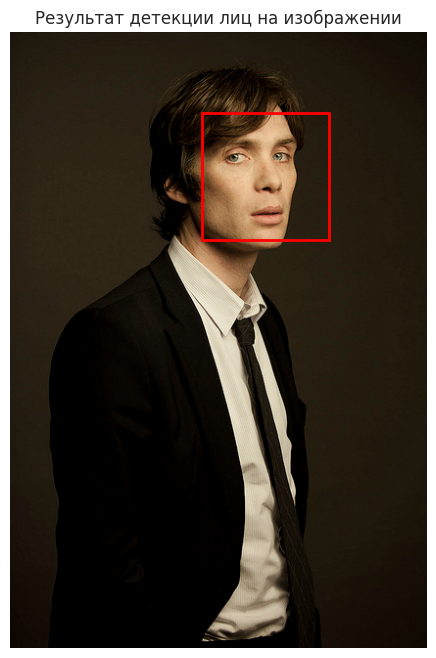

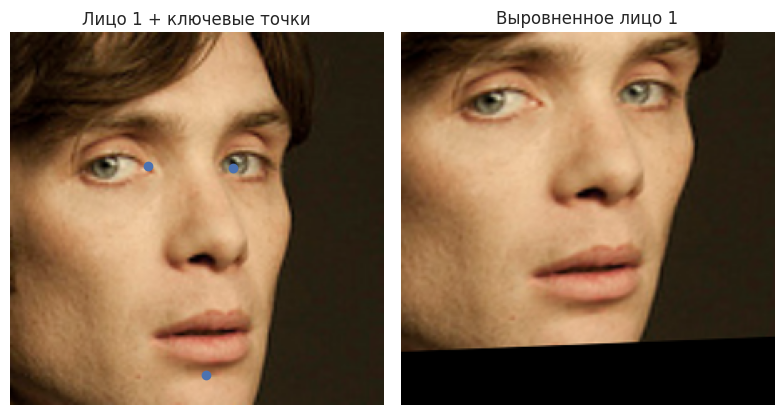

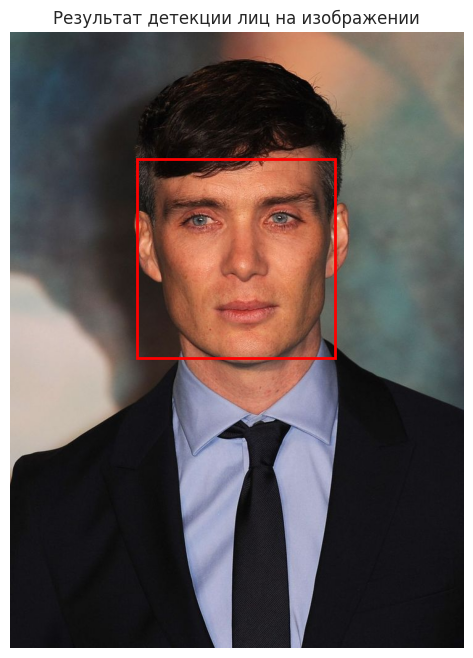

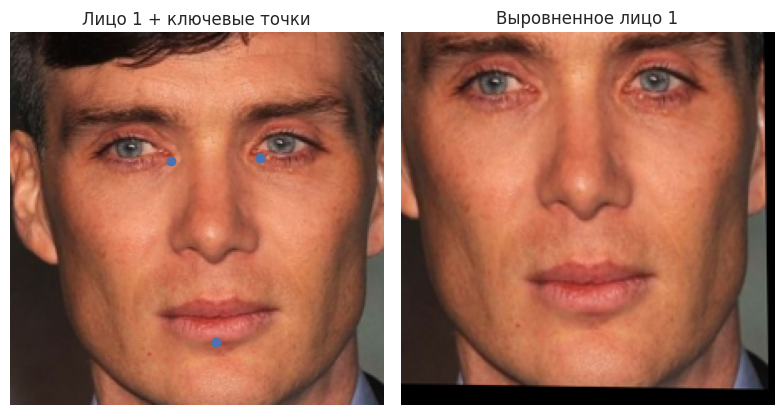

In [111]:
person_1_path_1 = face_alignment('/content/drive/MyDrive/Datasets Deep Learning/images for testing model/person_1',
                                 'person_1_image_1.png',
                                 '/content/drive/MyDrive/Datasets Deep Learning/images for testing model/aligned_person_1') # путь к выровненному изображению первого человека
person_1_path_2 = face_alignment('/content/drive/MyDrive/Datasets Deep Learning/images for testing model/person_1',
                                 'person_1_image_2.jpg',
                                 '/content/drive/MyDrive/Datasets Deep Learning/images for testing model/aligned_person_1') # путь к выровненному изображению первого человека
person_1_path = person_1_path_1 + person_1_path_2

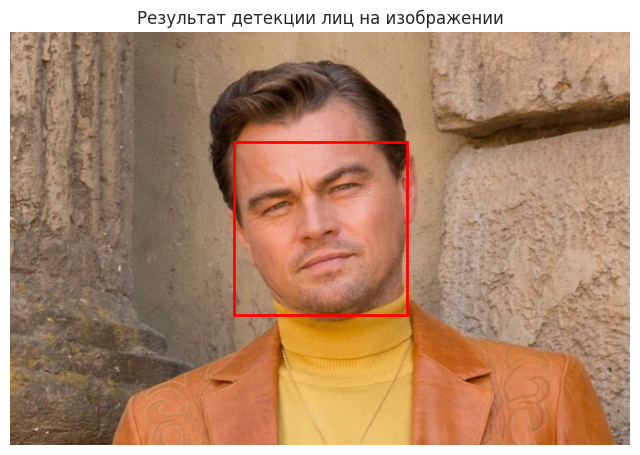

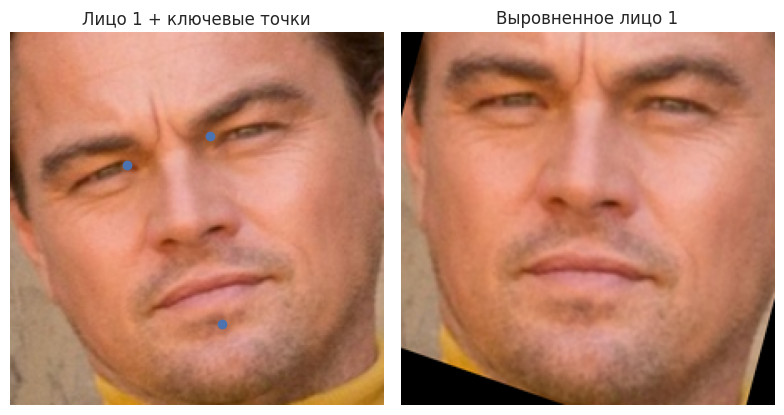

In [114]:
person_2_path = face_alignment('/content/drive/MyDrive/Datasets Deep Learning/images for testing model/person_2',
                                 'person_2_img_1.jpg',
                                 '/content/drive/MyDrive/Datasets Deep Learning/images for testing model/aligned_person_2') # путь к выровненному изображению второго человека

Посчитаем эмбеддинги для person 1

In [116]:
person_1_embs = compute_embeddings(arcface_model, person_1_path, '/content/drive/MyDrive/Datasets Deep Learning/images for testing model/aligned_person_1')
person_1_img_1_emb, person_1_img_2_emb = person_1_embs[0], person_1_embs[1]

100%|██████████| 2/2 [00:00<00:00, 71.17it/s]


Посчитаем эмбеддинги для person 2

In [117]:
person_2_embs = compute_embeddings(arcface_model, person_2_path, '/content/drive/MyDrive/Datasets Deep Learning/images for testing model/aligned_person_2')
person_2_img_1_emb = person_2_embs[0]

100%|██████████| 1/1 [00:00<00:00, 58.26it/s]


Посчитаем косинусное сходство сначала между одинаковыми изображениями первого человека

In [118]:
person_1_similarity = compute_cosine_similarity(person_1_img_1_emb, person_1_img_2_emb) # косинусное сходство между одинаковыми изображениями первого человека

Посчитаем косинусное сходство для пар изображений разных людей

In [119]:
person_1_person_2__similarity_11 = compute_cosine_similarity(person_1_img_1_emb, person_2_img_1_emb)
person_1_person_2__similarity_21 = compute_cosine_similarity(person_1_img_2_emb, person_2_img_1_emb)

In [120]:
print(f'cosine similarity between identical faces: {person_1_similarity:4f}')

cosine similarity between identical faces: 0.752199


In [121]:
print(f'cosine similarity between different faces: {person_1_person_2__similarity_11:4f}')
print(f'cosine similarity between different faces: {person_1_person_2__similarity_21:4f}')

cosine similarity between different faces: 0.478368
cosine similarity between different faces: 0.531017


**Итог:** в результате косинусная близость между парой изображений одного человека больше чем косинусная близость, рассчитанная между изображениями двух разных людей, как и должно быть. Это говорит о том, что построенный пайплайн справляется с задачей распознавания лиц.

# Используемая литература

*   https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
*   https://habr.com/ru/companies/ntechlab/articles/531842/

